#**BBM409: Machine Learning Laboratory**
==================================

**Programming Assignment-3**

**Instructors:** 
*   Ahmet Burak Can
*   Burçak Asal

**Prepared By:** 
* Mert Tazeoğlu `(21946606)`

**Problem Definition:** 

In this assignment, we will use Naive Bayes Algorithm in order to handle text classification problem.

#**Part-1: Understanding The Data**

##**1.1 - Importing Required Libraries**
*   **`Numpy:`** To perform a wide variety of mathematical operations on datasets.
*   **`Pandas:`** To analyse and manipulate tabular data in different dataframes.
*   **`Math:`** To make basic mathematical and statistical operations on dataframes.
*   **`Operator:`** To make critical dictionary operations in an easier way.
*   **`Itertools:`** To iterate and slice python dictionaries in an easier way.
*   **`Matplotlib:`** To visualize datasets and important statisctical informations.
*   **`WordCloud:`** To visualize most occuring keywords in categories effectively.
*   **`Stop Words:`** To perform text classification operations more accurate.
*   **`Copy:`** To create deep copies of data structures in order to prevent conclusions.

In [ ]:
import pandas as pd
import numpy as np
import math
import operator
import itertools
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import copy

##**1.2 - Dataset Preparation**

In [ ]:
# Uploading and reading dataset
df_name = "English Dataset.csv"
df = pd.read_csv(df_name)

# Storing names of columns
columnNames = np.array(df.columns)

df.head(3)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business


In [ ]:
# Removing 'ArticleId' column since it is useless for ML
df.drop('ArticleId', inplace=True, axis=1)

# Splitting data into different datasets by categories
business_df = df[df['Category'] == 'business']
tech_df = df[df['Category'] == 'tech']
politics_df = df[df['Category'] == 'politics']
sport_df = df[df['Category'] == 'sport']
entertainment_df = df[df['Category'] == 'entertainment']

# Converting dataframe to numpy array
df = np.array(df)

##**1.3 - Finding Specific Keywords With Statistics**

While some words in the language structure belong to certain categories (for example, the word computer belongs to the technology category), some words that make up the main structure of the language are used in many sentences regardless of category. For this reason, inferences can be made about the words affecting the category by performing word analysis on the texts whose categories are known. 

In order to provide such a statistic, we will provide wordclouds for each of categories. Word Cloud is a data visualization technique used for representing text data in which the size of each word **indicates its frequency or importance, which also provides important statistics.**

In [ ]:
stop_words = ENGLISH_STOP_WORDS

# Word cloud generator function
def wordcloud_draw(dataset):
  words = ' '.join(dataset)
  wordcloud = WordCloud(stopwords = stop_words, background_color = 'white', width = 1500, height = 1500).generate(words)
  plt.figure(1, figsize = (10,7))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

###**1.3.1 - Specific Keywords & Statistics for Business**

**Most Common Keywords:** Said, firm, year, sale, company, economy, share, director, bank, market, growth, price, government...

**5 Specific Keywords That May Be Useful:** Firm, sale, economy, company, market

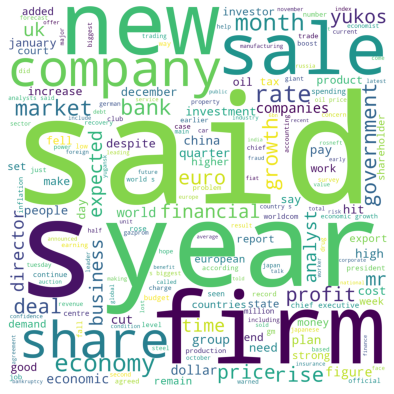

In [ ]:
wordcloud_draw(business_df['Text'])

###**1.3.2 - Specific Keywords & Statistics for Tech**

**Most Common Keywords:** Said, people, game, technology, could, use, also, mobile, service, site, firm, user, software, computer...

**5 Specific Keywords That May Be Useful:** Technology, game, mobile, software, computer

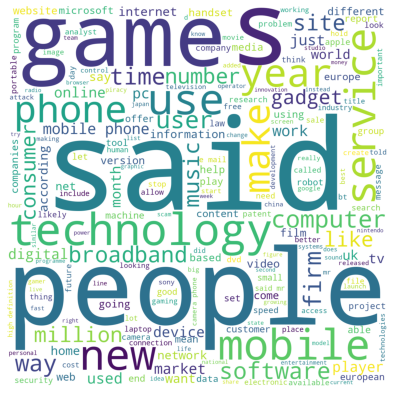

In [ ]:
wordcloud_draw(tech_df['Text'])

###**1.3.3 - Specific Keywords & Statistics for Politics**

**Most Common Keywords:** Would, said, labour, plan, government, people, mr, party, election, prime, minister, council, people...

**5 Specific Keywords That May Be Useful:** Government, election, party, council, labour

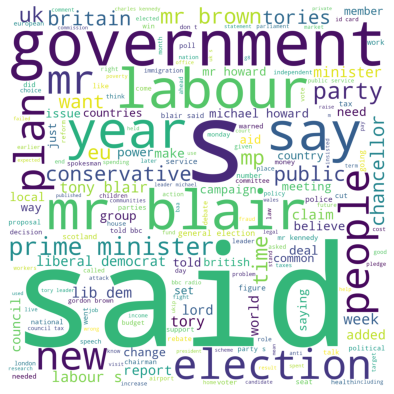

In [ ]:
wordcloud_draw(politics_df['Text'])

###**1.3.4 - Specific Keywords & Statistics for Sport**

**Most Common Keywords:** Said, game, win, player, england, first, team, back, wales, would, match, also, club, side, minute, play...

**5 Specific Keywords That May Be Useful:** Game, win, player, match, team 

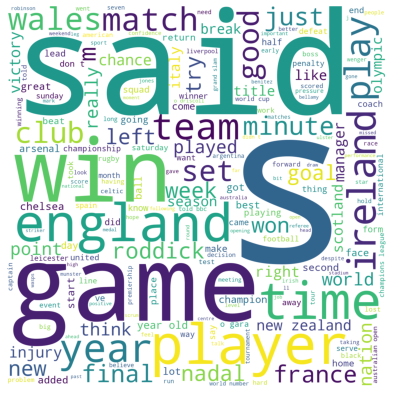

In [ ]:
wordcloud_draw(sport_df['Text'])

###**1.3.5 - Specific Keywords & Statistics for Entertainment**

**Most Common Keywords:** Film, said, year, music, award, best, would, also, album, show, first, star, actor, tv, band, oscar, actress...

**5 Specific Keywords That May Be Useful:** Film, music, award, actor, actress

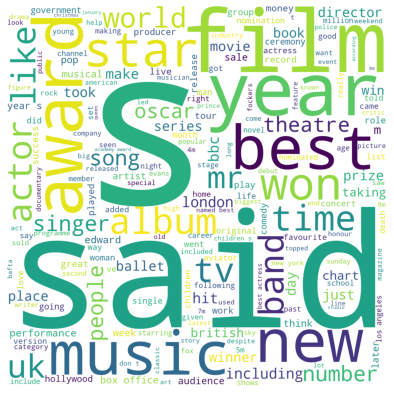

In [ ]:
wordcloud_draw(entertainment_df['Text'])

#**Part-2: Implementing The Naive Bayes (and Required Functions)**

*   **`Cross Validation Splitter:`** This function divides dataframe into k folds and returns one fold as validation dataset and others as training dataset. In each turn, index of validation dataset changes.

*   **`Bag Of Words Creator:`** This function returns a representation that turns arbitrary text into fixed-length vectors by counting how many times each word.

*   **`TF-IDF Calculator:`** This function calculates TF-IDF or TF value of given inputs according to the given function paramters.

*   **`Log Probability Calculator:`** This function calculates logaritmic probabilities for each vector in the bag of words model. In order to prevent numerical underflow, we use log probabilities.

*   **`Prediction Maker:`** This function makes a class prediction which based on naive bayes algorithm and which makes prediction with using calculated probabilities.

*   **`Naive Bayes Predictor:`** This function calculates initial probabilities, finds most effective keywords and calls naive bayes prediction maker function for each of sample in the test set.

*   **`Metric Evaluator:`** This function calculates models accuracy, precision, recall and F1-score metrics with creating a confusion matrix.

In [ ]:
def kFoldCrossValidationSplit(dataframe, k, test_index):
    # Step-1: Splitting dataset into k folds
    folds = np.array_split(dataframe, k)
    trainFolds = [];
    
    # Step-2: Deciding indexes of train and validation parts
    for i in range(k):
        if i == test_index:
            # Assigning validation dataset
            testSet = folds[test_index]
        else:
            trainFolds.append(folds[i]);
    
    # Step-3: Assigning train dataset
    trainSet = trainFolds.pop(0)   
    for i in range(len(trainFolds)):
        trainSet = np.concatenate((trainSet, trainFolds[i]), axis=0)
        
    # Step-4: Returning both of training and testing datasets
    return trainSet, testSet

In [ ]:
def BagOfWordsCreator(trainSet, includeStopWords, keywordType = [True, True]):

  # Example Outputs: (for 20 articles and limited for first 7 keywords)
  # bagOfWords:         {'business': {'s': 16, 'profits': 14, '-': 11, 'said': 10, 'mercedes': 9, 'oil': 9, 'euros': 8}, 'tech': {'': 9, 'mobile': 4, 'users': 3, 'golf': 2, 'swing': 2, 'responds': 2, 'launched': 2}, 'politics': {'mr': 12, 's': 12, 'said': 8, '-': 8, 'advice': 8, 'howard': 7, 'snooker': 7}, 'sport': {'s': 21, 'ireland': 13, 'williams': 8, 'o': 8, 'gara': 8, 'club': 7, 'argentina': 6}, 'entertainment': {'s': 18, '-': 11, 'film': 8, 'band': 8, 'christmas': 6, 'fockers': 5, 'meet': 5}}
  # oppositeBagOfWords: {'business': {'s': 53, '-': 23, 'mr': 15, 'said': 15, 'ireland': 13, 'phone': 12, 'new': 12}, 'tech': {'s': 67, '-': 32, 'said': 25, 'new': 16, 'said.': 16, 'mr': 16, 'profits': 14}, 'politics': {'s': 57, '-': 26, 'said': 17, 'new': 17, 'profits': 14, 'said.': 13, 'ireland': 13}, 'sport': {'s': 48, '-': 32, 'said': 20, 'mr': 16, 'profits': 14, 'lord': 13, 'year': 12}, 'entertainment': {'s': 51, '-': 23, 'said': 23, 'profits': 14, 'mr': 13, 'ireland': 13, 'new': 12}}

  # Step-1: Initializing the BOW dictionary
  bagOfWords = {}          # Most common keywords for each of categories (for example business subdict in it includes critical keywords for business)
  oppositeBagOfWords = {}  # Most common keywords for other categories (for example business subdict in it includes critical keywords for other 4 categories)

  # Step-2: Creating sub BOW dictionaries for each of categories
  business_BOW = {}
  tech_BOW = {}
  politics_BOW = {}
  sport_BOW = {}
  entertainment_BOW = {}

  # Step-3: Calculating logaritmic probabilites for each category
  for i in range(trainSet.shape[0]):
    splittedText = trainSet[i][0].split(" ")

    # Step-3.1: Calculating logaritmic probabilites in unigram format
    for j in range(len(splittedText)):
      if(keywordType[0] == True):
        if((splittedText[j] not in ENGLISH_STOP_WORDS) != includeStopWords):
          if(trainSet[i][1] == 'business'):
            if splittedText[j] in business_BOW: business_BOW[splittedText[j]] += 1
            else: business_BOW[splittedText[j]] = 1

          elif(trainSet[i][1] == 'tech'):
            if splittedText[j] in tech_BOW: tech_BOW[splittedText[j]] += 1
            else: tech_BOW[splittedText[j]] = 1

          elif(trainSet[i][1] == 'politics'):
            if splittedText[j] in politics_BOW: politics_BOW[splittedText[j]] += 1
            else: politics_BOW[splittedText[j]] = 1

          elif(trainSet[i][1] == 'sport'):
            if splittedText[j] in sport_BOW: sport_BOW[splittedText[j]] += 1
            else: sport_BOW[splittedText[j]] = 1

          elif(trainSet[i][1] == 'entertainment'):
            if splittedText[j] in entertainment_BOW: entertainment_BOW[splittedText[j]] += 1
            else: entertainment_BOW[splittedText[j]] = 1

    # Step-3.2: Calculating logaritmic probabilites in bigram format
    for j in range(len(splittedText)-1):
      if(keywordType[1] == True):
        if( ((splittedText[j] + " " + splittedText[j+1]) in ENGLISH_STOP_WORDS) != includeStopWords):
          if(trainSet[i][1] == 'business'):
            if (splittedText[j] + " " + splittedText[j+1]) in business_BOW: business_BOW[(splittedText[j] + " " + splittedText[j+1])] += 1
            else: business_BOW[(splittedText[j] + " " + splittedText[j+1])] = 1

          elif(trainSet[i][1] == 'tech'):
            if (splittedText[j] + " " + splittedText[j+1]) in tech_BOW: tech_BOW[(splittedText[j] + " " + splittedText[j+1])] += 1
            else: tech_BOW[(splittedText[j] + " " + splittedText[j+1])] = 1

          elif(trainSet[i][1] == 'politics'):
            if (splittedText[j] + " " + splittedText[j+1]) in politics_BOW: politics_BOW[(splittedText[j] + " " + splittedText[j+1])] += 1
            else: politics_BOW[(splittedText[j] + " " + splittedText[j+1])] = 1

          elif(trainSet[i][1] == 'sport'):
            if (splittedText[j] + " " + splittedText[j+1]) in sport_BOW: sport_BOW[(splittedText[j] + " " + splittedText[j+1])] += 1
            else: sport_BOW[(splittedText[j] + " " + splittedText[j+1])] = 1

          elif(trainSet[i][1] == 'entertainment'):
            if (splittedText[j] + " " + splittedText[j+1]) in entertainment_BOW: entertainment_BOW[(splittedText[j] + " " + splittedText[j+1])] += 1
            else: entertainment_BOW[(splittedText[j] + " " + splittedText[j+1])] = 1

  # Step-5: Sorting the dictionaries in descending order
  business_BOW = dict(sorted(business_BOW.items(), key=operator.itemgetter(1), reverse=True))
  tech_BOW = dict(sorted(tech_BOW.items(), key=operator.itemgetter(1), reverse=True))
  politics_BOW = dict(sorted(politics_BOW.items(), key=operator.itemgetter(1), reverse=True))
  sport_BOW = dict(sorted(sport_BOW.items(), key=operator.itemgetter(1), reverse=True))
  entertainment_BOW = dict(sorted(entertainment_BOW.items(), key=operator.itemgetter(1), reverse=True))

  # Step-6: Adding all of them into main BOW
  bagOfWords['business'] = business_BOW
  bagOfWords['tech'] = tech_BOW
  bagOfWords['politics'] = politics_BOW
  bagOfWords['sport'] = sport_BOW
  bagOfWords['entertainment'] = entertainment_BOW

  # Step-7: Creating opposite of bag of words (in other words, words that not in that category)
  for category in ('business', 'tech', 'politics', 'sport', 'entertainment'):
    if category == 'business':
      businessNonDict = {}
      for temp in (tech_BOW, politics_BOW, sport_BOW, entertainment_BOW):
        for key in list(temp.keys()):
          if key in list(businessNonDict.keys()): businessNonDict[key] += temp[key]
          else: businessNonDict[key] = temp[key]
      businessNonDict = dict(sorted(businessNonDict.items(), key=operator.itemgetter(1), reverse=True)) # Sorting
      oppositeBagOfWords['business'] = businessNonDict

    elif category == 'tech':
      techNonDict = {}
      for temp in (business_BOW, politics_BOW, sport_BOW, entertainment_BOW):
        for key in list(temp.keys()):
          if key in list(techNonDict.keys()): techNonDict[key] += temp[key]
          else: techNonDict[key] = temp[key]
      techNonDict = dict(sorted(techNonDict.items(), key=operator.itemgetter(1), reverse=True)) # Sorting
      oppositeBagOfWords['tech'] = techNonDict

    elif category == 'politics':
      politicsNonDict = {}
      for temp in (business_BOW, tech_BOW, sport_BOW, entertainment_BOW):
        for key in list(temp.keys()):
          if key in list(politicsNonDict.keys()): politicsNonDict[key] += temp[key]
          else: politicsNonDict[key] = temp[key]
      politicsNonDict = dict(sorted(politicsNonDict.items(), key=operator.itemgetter(1), reverse=True)) # Sorting
      oppositeBagOfWords['politics'] = politicsNonDict

    elif category == 'sport':
      sportNonDict = {}
      for temp in (business_BOW, tech_BOW, politics_BOW, entertainment_BOW):
        for key in list(temp.keys()):
          if key in list(sportNonDict.keys()): sportNonDict[key] += temp[key]
          else: sportNonDict[key] = temp[key]
      sportNonDict = dict(sorted(sportNonDict.items(), key=operator.itemgetter(1), reverse=True)) # Sorting
      oppositeBagOfWords['sport'] = sportNonDict

    elif category == 'entertainment':
      entertainmentNonDict = {}
      for temp in (business_BOW, tech_BOW, politics_BOW, sport_BOW):
        for key in list(temp.keys()):
          if key in list(entertainmentNonDict.keys()): entertainmentNonDict[key] += temp[key]
          else: entertainmentNonDict[key] = temp[key]
      entertainmentNonDict = dict(sorted(entertainmentNonDict.items(), key=operator.itemgetter(1), reverse=True)) # Sorting
      oppositeBagOfWords['entertainment'] = entertainmentNonDict

  # Step-8: Returning zipped BOW dictionaries
  return bagOfWords, oppositeBagOfWords

In [ ]:
def calculateTFIDF(probDict, key, colName, probabilityMode):
  TF = probDict[colName][key] / sum(probDict[colName].values())
  IDF = math.log2(sum(probDict[colName].values()) / probDict[colName][key])
  if probabilityMode == "TF-IDF": return TF * IDF # Return TF-IDF
  else: return TF # Return TF

In [ ]:
def calculateLogProbabilities(bagOfWords, oppositeBagOfWords, limitOfKeywords, probabilityMode, influencePresence):

  # Example Outputs: (for 20 articles and limited for first 7 keywords)
  # logProbabilities:         {'business': {'s': 0.4710205798846549, 'profits': 0.44716938520678134, '-': 0.40105070315108626, 'said': 0.38244914880617387, 'mercedes': 0.3619708292632896, 'oil': 0.3619708292632896, 'euros': 0.33940639383843135}, 'tech': {'': 0.5306390622295664, 'mobile': 0.430827083453526, 'users': 0.375, 'golf': 0.29874687506009634, 'swing': 0.29874687506009634, 'responds': 0.29874687506009634, 'launched': 0.29874687506009634}, 'politics': {'mr': 0.45856138251594564, 's': 0.45856138251594564, 'said': 0.3811866206950807, '-': 0.3811866206950807, 'advice': 0.3811866206950807, 'howard': 0.3552885438436274, 'snooker': 0.3552885438436274}, 'sport': {'s': 0.519803149735836, 'ireland': 0.448464735460939, 'williams': 0.3549010838878515, 'o': 0.3549010838878515, 'gara': 0.3549010838878515, 'club': 0.3295316251004161, 'argentina': 0.30124940440424164}, 'entertainment': {'s': 0.5195839680355792, '-': 0.44564529357674565, 'film': 0.3843589950902146, 'band': 0.3843589950902146, 'christmas': 0.3290926069024653, 'fockers': 0.295804036284879, 'meet': 0.295804036284879}}
  # oppositeLogProbabilities: {'business': {'s': 0.530723054247588, '-': 0.42402178850763395, 'mr': 0.3412217560667697, 'said': 0.3412217560667697, 'ireland': 0.3144937835124816, 'phone': 0.29999234987892864, 'new': 0.29999234987892864}, 'tech': {'s': 0.5306218525998244, '-': 0.436844526642242, 'said': 0.3891535781361971, 'new': 0.3044437686974651, 'said.': 0.3044437686974651, 'mr': 0.3044437686974651, 'profits': 0.28088846476723645}, 'politics': {'s': 0.5306920501874679, '-': 0.42960959744913313, 'said': 0.34727187534969356, 'new': 0.34727187534969356, 'profits': 0.31096637946290645, 'said.': 0.2976073464952672, 'ireland': 0.2976073464952672}, 'sport': {'s': 0.5237146543132123, '-': 0.4699095546372619, 'said': 0.3811866206950807, 'mr': 0.33818058377024385, 'profits': 0.3133082113873088, 'lord': 0.2998961350498767, 'year': 0.28576737325572243}, 'entertainment': {'s': 0.5294221617652615, '-': 0.4161003421564995, 'said': 0.4161003421564995, 'profits': 0.32057308978297855, 'mr': 0.30700318409512684, 'ireland': 0.30700318409512684, 'new': 0.29268773313350377}}
  
  # Step-1: Initializing the log probability dictionaries
  logProbabilities = {}         # Log probabilities for most common keywords for each of categories (for example business subdict in it includes critical keywords for business)
  oppositeLogProbabilities = {} # Log probabilities for most common keywords for other categories (for example business subdict in it includes critical keywords for other 4 categories)

  # Step-2.1: Limiting total number of the results as 'limitOfKeywords' at the beginning in order to improve execution time
  bagOfWords['business'] = dict(itertools.islice(bagOfWords['business'].items(), 1, limitOfKeywords+1))
  bagOfWords['tech'] = dict(itertools.islice(bagOfWords['tech'].items(), 1, limitOfKeywords+1))
  bagOfWords['politics'] = dict(itertools.islice(bagOfWords['politics'].items(), 1, limitOfKeywords+1))
  bagOfWords['sport'] = dict(itertools.islice(bagOfWords['sport'].items(), 1, limitOfKeywords+1))
  bagOfWords['entertainment'] = dict(itertools.islice(bagOfWords['entertainment'].items(), 1, limitOfKeywords+1))

  # Step-2.2: Limiting total number of the results as 'limitOfKeywords' at the beginning in order to improve execution time
  # Note: If 'influencePresence' parameter is not configured as 'Presence+Absence(PR+AB)', than it won't use effective keywords of absence
  if(influencePresence != 'PR+AB'): limitOfKeywords = 0
  oppositeBagOfWords['business'] = dict(itertools.islice(oppositeBagOfWords['business'].items(), 1, limitOfKeywords+1))
  oppositeBagOfWords['tech'] = dict(itertools.islice(oppositeBagOfWords['tech'].items(), 1, limitOfKeywords+1))
  oppositeBagOfWords['politics'] = dict(itertools.islice(oppositeBagOfWords['politics'].items(), 1, limitOfKeywords+1))
  oppositeBagOfWords['sport'] = dict(itertools.islice(oppositeBagOfWords['sport'].items(), 1, limitOfKeywords+1))
  oppositeBagOfWords['entertainment'] = dict(itertools.islice(oppositeBagOfWords['entertainment'].items(), 1, limitOfKeywords+1))

  # Step-3.1: Calculating logarithmic probabilities for business (which are in business)
  businessProbabilities = {}
  for key in bagOfWords['business'].keys():
    businessProbabilities[key] = calculateTFIDF(bagOfWords, key, 'business', probabilityMode)
  logProbabilities['business'] = businessProbabilities

  # Step-3.2: Calculating logarithmic probabilities for tech (which are in tech)
  techProbabilities = {}
  for key in bagOfWords['tech'].keys():
    techProbabilities[key] = calculateTFIDF(bagOfWords, key, 'tech', probabilityMode)
  logProbabilities['tech'] = techProbabilities

  # Step-3.3: Calculating logarithmic probabilities for politics (which are in politics)
  politicsProbabilities = {}
  for key in bagOfWords['politics'].keys():
    politicsProbabilities[key] = calculateTFIDF(bagOfWords, key, 'politics', probabilityMode)
  logProbabilities['politics'] = politicsProbabilities

  # Step-3.4: Calculating logarithmic probabilities for sport (which are in sport)
  sportProbabilities = {}
  for key in bagOfWords['sport'].keys():
    sportProbabilities[key] = calculateTFIDF(bagOfWords, key, 'sport', probabilityMode)
  logProbabilities['sport'] = sportProbabilities

  # Step-3.5: Calculating logarithmic probabilities for entertainment (which are in entertainment)
  entertainmentProbabilities = {}
  for key in bagOfWords['entertainment'].keys():
    entertainmentProbabilities[key] = calculateTFIDF(bagOfWords, key, 'entertainment', probabilityMode)
  logProbabilities['entertainment'] = entertainmentProbabilities

  # Step-4.1: Calculating opposite logarithmic probabilities for business (which are "NOT" in business)
  oppositeBusinessProbabilities = {}
  for key in oppositeBagOfWords['business'].keys():
    oppositeBusinessProbabilities[key] = calculateTFIDF(oppositeBagOfWords, key, 'business', probabilityMode)
  oppositeLogProbabilities['business'] = oppositeBusinessProbabilities

  # Step-4.2: Calculating opposite logarithmic probabilities for tech (which are "NOT" in tech)
  oppositeTechProbabilities = {}
  for key in oppositeBagOfWords['tech'].keys():
    oppositeTechProbabilities[key] = calculateTFIDF(oppositeBagOfWords, key, 'tech', probabilityMode)
  oppositeLogProbabilities['tech'] = oppositeTechProbabilities

  # Step-4.3: Calculating opposite logarithmic probabilities for politics (which are "NOT" in politics)
  oppositePoliticsProbabilities = {}
  for key in oppositeBagOfWords['politics'].keys():
    oppositePoliticsProbabilities[key] = calculateTFIDF(oppositeBagOfWords, key, 'politics', probabilityMode)
  oppositeLogProbabilities['politics'] = oppositePoliticsProbabilities

  # Step-4.4: Calculating opposite logarithmic probabilities for sport (which are "NOT" in sport)
  oppositeSportProbabilities = {}
  for key in oppositeBagOfWords['sport'].keys():
    oppositeSportProbabilities[key] = calculateTFIDF(oppositeBagOfWords, key, 'sport', probabilityMode)
  oppositeLogProbabilities['sport'] = oppositeSportProbabilities

  # Step-4.5: Calculating opposite logarithmic probabilities for entertainment (which are "NOT" in entertainment)
  oppositeEntertainmentProbabilities = {}
  for key in oppositeBagOfWords['entertainment'].keys():
    oppositeEntertainmentProbabilities[key] = calculateTFIDF(oppositeBagOfWords, key, 'entertainment', probabilityMode)
  oppositeLogProbabilities['entertainment'] = oppositeEntertainmentProbabilities

  # Step-5: Returning whole logarithmic probabilities
  return logProbabilities, oppositeLogProbabilities

  # Note: No need for sorting since we sorted them while creating BOW's (and therefore it comes with automatically sorted version)

In [ ]:
def makePrediction(bagOfWords, sample, main_probabilities, logProbabilities, oppositeLogProbabilities):

  # Example Output:
  # {'tech': 11.996279145855127, 'politics': 7.890419855049961, 'entertainment': 7.271334041235052, 'business': 7.263775912925541, 'sport': 6.573072326595047}

  # Step-1: Defining main probabilities
  # Note: They are non zero (and we don't care about non-existing values), therefore we prevented issues of 0 probabilities (Laplace Smoothing)
  # Note-2: We use deep copy, otherwise somehow it updates it and therefore after a certain period of time always same value is predicted.
  probabilities = copy.deepcopy(main_probabilities)
  
  # Step-2: Calculating probabilities for given test sample
  sampleData = sample[0].split(" ")
  for i in range(len(sampleData)):

    # Step-2.1: Positive cases (keywords that in current category)
    if(sampleData[i] in logProbabilities['business'].keys()): probabilities['business'] += abs(logProbabilities['business'][sampleData[i]])
    if(sampleData[i] in logProbabilities['tech'].keys()): probabilities['tech'] += abs(logProbabilities['tech'][sampleData[i]])
    if(sampleData[i] in logProbabilities['politics'].keys()): probabilities['politics'] += abs(logProbabilities['politics'][sampleData[i]])
    if(sampleData[i] in logProbabilities['sport'].keys()): probabilities['sport'] += abs(logProbabilities['sport'][sampleData[i]])
    if(sampleData[i] in logProbabilities['entertainment'].keys()): probabilities['entertainment'] += abs(logProbabilities['entertainment'][sampleData[i]])
    
    # Step-2.2: Negative cases (keywords that NOT in current category)
    try: 
      if(sampleData[i] in oppositeLogProbabilities['business'].keys()): probabilities['business'] += (abs(oppositeLogProbabilities['business'][sampleData[i]]))
    except: pass
    try: 
      if(sampleData[i] in oppositeLogProbabilities['tech'].keys()): probabilities['tech'] += (abs(oppositeLogProbabilities['tech'][sampleData[i]]))
    except: pass
    try: 
      if(sampleData[i] in oppositeLogProbabilities['politics'].keys()): probabilities['politics'] += (abs(oppositeLogProbabilities['politics'][sampleData[i]]))
    except: pass
    try: 
      if(sampleData[i] in oppositeLogProbabilities['sport'].keys()): probabilities['sport'] += (abs(oppositeLogProbabilities['sport'][sampleData[i]]))
    except: pass
    try:
      if(sampleData[i] in oppositeLogProbabilities['entertainment'].keys()): probabilities['entertainment'] += (abs(oppositeLogProbabilities['entertainment'][sampleData[i]]))
    except: pass
    # Note: There can't be exact match in everytime, therefore i pass these situations (they won't affect result naturally)

    # Step-3: Sorting probabilities and selecting most probable one
    probabilities = dict(sorted(probabilities.items(), key=operator.itemgetter(1), reverse=True))

  # Step-4: Returning most probable one
  # Hint: Since result is in logaritmic format, least one is most probable
  return list(probabilities.keys())[0]

In [ ]:
def naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, limitOfKeywords, probabilityMode, influencePresence, willPrint, NUMBER_OF_KEYWORDS_TO_PRINT = 10):
  predictions = list()

  # Step-1: Calculating main probabilities
  main_probabilities = {}
  main_probabilities['business'] = abs(math.log2((business_df.shape[0] / df.shape[0])))
  main_probabilities['tech'] = abs(math.log2((tech_df.shape[0] / df.shape[0])))
  main_probabilities['politics'] = abs(math.log2((politics_df.shape[0] / df.shape[0])))
  main_probabilities['sport'] = abs(math.log2((sport_df.shape[0] / df.shape[0])))
  main_probabilities['entertainment'] = abs(math.log2((entertainment_df.shape[0] / df.shape[0])))
  # In Standart Format: {'business': '0.23', 'tech': '0.18', 'politics': '0.18', 'sport': '0.23', 'entertainment': '0.18'}
  # But here they are stored in logarithmic format.

  # Step-2: Calculating logarithmic probabilities
  logProbabilities, oppositeLogProbabilities = calculateLogProbabilities(bagOfWords, oppositeBagOfWords, limitOfKeywords, probabilityMode, influencePresence)
  
  if(willPrint):
    print("")
    print("--- Most Effective Presence Keywords For Each Category ---")
    for key in list(logProbabilities.keys()):
      print(str(key) + "-> [", end = "")
      i=0
      for subkey in list(logProbabilities[key].keys()):
        if(i<NUMBER_OF_KEYWORDS_TO_PRINT):
          print(str(subkey), end = ", ")
          i+=1
      print("]", end = "")
      print("")
    print("")
    print("--- Most Effective Absence Keywords For Each Category ---")
    for key in list(oppositeLogProbabilities.keys()):
      print(str(key) + "-> [", end = "")
      i=0
      for subkey in list(oppositeLogProbabilities[key].keys()):
        if(i<10):
          print(str(subkey), end = ", ")
          i+=1
      print("]", end = "")
      print("")

  # Step-3: Making predictions for each of sample
  for i in range(testSet.shape[0]):
    predictions.append(makePrediction(bagOfWords, testSet[i], main_probabilities, logProbabilities, oppositeLogProbabilities))

  # Step-4: Returning all predictions
  return predictions

In [ ]:
# This function evaluates model performance and calculates most important metrics
def metric_evaluation(actual, predicted):
	accuracy = 0.0
	precision = 0.0
	recall = 0.0

  # Step-1: Encoding given arrays of actual and predicted values
	for i in range(len(actual)):
		if actual[i] == 'business': actual[i] = 0
		if predicted[i] == 'business': predicted[i] = 0
		if actual[i] == 'tech':	actual[i] = 1
		if predicted[i] == 'tech': predicted[i] = 1
		if actual[i] == 'politics': actual[i] = 2
		if predicted[i] == 'politics': predicted[i] = 2
		if actual[i] == 'sport': actual[i] = 3
		if predicted[i] == 'sport': predicted[i] = 3
		if actual[i] == 'entertainment': actual[i] = 4
		if predicted[i] == 'entertainment': predicted[i] = 4

	# Step-2: Creation of 5x5 confusion matrix
	confusion_matrix = []
	for i in range(5):
		sub = [0]
		for j in range(5):
			sub.append(0)
		confusion_matrix.append(sub)

	for i in range(len(actual)):
		try:
			if(actual[i] == predicted[i]):
				confusion_matrix[int(actual[i])][int(actual[i])] += 1 
			elif(actual[i] != predicted[i]):
				confusion_matrix[int(actual[i])][int(predicted[i])] += 1
		except: pass

	# Step-3: Calculation of model accuracy
	positive = 0.0
	for i in range(5):
		if(confusion_matrix[i][i] > 0):
			positive += confusion_matrix[i][i]
	accuracy = positive / float(len(actual)) * 100.0

	# Step-4: Calculation of model precision
	for i in range(5):
		temp = 0.0
		try: # Try-except is required since there can be some zero division errors due to zero values in the confusion matrix 
			for j in range(5):
				temp += confusion_matrix[j][i]
			precision += (confusion_matrix[i][i] / temp)
		except:
			pass

	# Step-5: Calculation of model recall
	for i in range(5):
		temp = 0.0
		try: # Try-except is required since there can be some zero division errors due to zero values in the confusion matrix 
			for j in range(5):
				temp += confusion_matrix[i][j]
			recall += (confusion_matrix[i][i] / temp)
		except:
			pass

  # Step-6: Returning whole metrics
	return accuracy, precision*100/5, recall*100/5

#**Part-3: Model Evaluation and Performance Analysis**


###**Part-3.1: Effect of Presence and Absence of Keywords (If Stop Words Are Included)**
While classifying, we created separate BOW models for each category both for the words that are in that category (presence keywords) and for words that are not in that category (absence keywords). As we explore the ideal settings for the model we are developing, our first experiment will be whether using all the situations or just the words in the category will work better.

In [ ]:
print("If Both of Presence and Absence Cases Are Considered")
for i in range(5):
  print("          --- Current Fold Number : " + str(i+1) + " ---")
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, True)
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 300, 'TF-IDF', 'PR+AB', False))
  print(' Accuracy ' + str("{:.2f}".format(accuracy)) + ' - Precision: ' + str("{:.2f}".format(precision)) + ' - Recall: ' + str("{:.2f}".format(recall)))

print("")

print("      If Only Presence Cases Are Considered")
for i in range(5):
  print("          --- Current Fold Number : " + str(i+1) + " ---")
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, True)
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 300, 'TF-IDF', 'PR', False))
  print(' Accuracy ' + str("{:.2f}".format(accuracy)) + ' - Precision: ' + str("{:.2f}".format(precision)) + ' - Recall: ' + str("{:.2f}".format(recall)))

If Both of Presence and Absence Cases Are Considered
          --- Current Fold Number : 1 ---
 Accuracy 44.09 - Precision: 35.68 - Recall: 49.96
          --- Current Fold Number : 2 ---
 Accuracy 37.63 - Precision: 39.71 - Recall: 43.56
          --- Current Fold Number : 3 ---
 Accuracy 40.86 - Precision: 40.60 - Recall: 48.43
          --- Current Fold Number : 4 ---
 Accuracy 45.16 - Precision: 36.64 - Recall: 48.57
          --- Current Fold Number : 5 ---
 Accuracy 43.48 - Precision: 40.36 - Recall: 40.73

      If Only Presence Cases Are Considered
          --- Current Fold Number : 1 ---
 Accuracy 45.16 - Precision: 55.49 - Recall: 50.65
          --- Current Fold Number : 2 ---
 Accuracy 40.86 - Precision: 56.04 - Recall: 44.45
          --- Current Fold Number : 3 ---
 Accuracy 41.94 - Precision: 57.63 - Recall: 48.38
          --- Current Fold Number : 4 ---
 Accuracy 46.24 - Precision: 56.10 - Recall: 49.23
          --- Current Fold Number : 5 ---
 Accuracy 42.39 - Preci

**Experiment Results:** 
*   If we include everything, than models execution performance decreases dramatically. (Execution Time: ~1 Hour 20 Minutes)
*   Model works better (in terms of both of execution time and classification performance) if we consider only presence cases.
*   Especially precision metric become much better if we consider only presence cases.


###**Part-3.2: Effect of Presence and Absence of Keywords (If Stop Words Are "Not" Included)**
Lets make same experiment but this time we won't include stop words.

In [ ]:
print("If Both of Presence and Absence Cases Are Considered")
for i in range(5):
  print("          --- Current Fold Number : " + str(i+1) + " ---")
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, False) # Second parameter changed
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 300, 'TF-IDF', 'PR+AB', False))
  print(' Accuracy ' + str("{:.2f}".format(accuracy)) + ' - Precision: ' + str("{:.2f}".format(precision)) + ' - Recall: ' + str("{:.2f}".format(recall)))

print("")

print("      If Only Presence Cases Are Considered")
for i in range(5):
  print("          --- Current Fold Number : " + str(i+1) + " ---")
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, False) # Second parameter changed
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 300, 'TF-IDF', 'PR', False))
  print(' Accuracy ' + str("{:.2f}".format(accuracy)) + ' - Precision: ' + str("{:.2f}".format(precision)) + ' - Recall: ' + str("{:.2f}".format(recall)))

If Both of Presence and Absence Cases Are Considered
          --- Current Fold Number : 1 ---
 Accuracy 66.67 - Precision: 76.53 - Recall: 73.42
          --- Current Fold Number : 2 ---
 Accuracy 62.37 - Precision: 75.44 - Recall: 67.95
          --- Current Fold Number : 3 ---
 Accuracy 66.67 - Precision: 78.59 - Recall: 74.74
          --- Current Fold Number : 4 ---
 Accuracy 74.19 - Precision: 82.30 - Recall: 76.30
          --- Current Fold Number : 5 ---
 Accuracy 68.48 - Precision: 79.93 - Recall: 71.65

      If Only Presence Cases Are Considered
          --- Current Fold Number : 1 ---
 Accuracy 74.19 - Precision: 79.58 - Recall: 79.70
          --- Current Fold Number : 2 ---
 Accuracy 75.27 - Precision: 80.67 - Recall: 79.77
          --- Current Fold Number : 3 ---
 Accuracy 79.57 - Precision: 84.47 - Recall: 84.50
          --- Current Fold Number : 4 ---
 Accuracy 86.02 - Precision: 88.39 - Recall: 87.04
          --- Current Fold Number : 5 ---
 Accuracy 78.26 - Preci

**Experiment Results:** 
*   If we don't include stop words, than models execution performance increases. (New Execution Time: ~3 Minute 40 Seconds)
*   Model works better (in terms of both of execution time and classification performance) if we consider only presence cases.
*   Especially precision metric become much better if we consider only presence cases.

**About Stop Words' Effect Of Model:**

Common words that carry little (or perhaps no) meaningful information are called stop words. These words are very common and typically don’t add much to the meaning of a text but instead ensure the structure of a sentence is sound. [1]

Since stop words are included in all of categories and since they can't belong to any category for that reason (they dont have meaningful information); it's a wise choice to drop these words. In this way, we both shorten the working time of the model and enable it to make more accurate predictions.

**Reference:**

[1] -> https://smltar.com/stopwords.html

###**Part-3.3: Effect of Usage Of TF and TF-IDF**
We have two different options about calculating logaritmic probabilies for each vector in bag of words model. We can use term frequency (TF) or term frequency - inverse document frequency (TF-IDF). This experiment will be about which will work better.

In [ ]:
print("--- If Term Frequency Calculation Is Preferred ---")
for i in range(5):
  print("         --- Current Fold Number : " + str(i+1) + " ---")
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, False)
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 300, 'TF', 'PR+AB', False))
  print('Accuracy ' + str("{:.2f}".format(accuracy)) + ' - Precision: ' + str("{:.2f}".format(precision)) + ' - Recall: ' + str("{:.2f}".format(recall)))

print("")

print("   --- If TF-IDF Calculation Is Preferred ---")
for i in range(5):
  print("         --- Current Fold Number : " + str(i+1) + " ---")
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, False)
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 300, 'TF-IDF', 'PR+AB', False))
  print('Accuracy ' + str("{:.2f}".format(accuracy)) + ' - Precision: ' + str("{:.2f}".format(precision)) + ' - Recall: ' + str("{:.2f}".format(recall)))


--- If Term Frequency Calculation Is Preferred ---
         --- Current Fold Number : 1 ---
Accuracy 23.66 - Precision: 31.82 - Recall: 30.93
         --- Current Fold Number : 2 ---
Accuracy 25.81 - Precision: 36.99 - Recall: 33.03
         --- Current Fold Number : 3 ---
Accuracy 27.96 - Precision: 35.56 - Recall: 33.52
         --- Current Fold Number : 4 ---
Accuracy 30.11 - Precision: 35.86 - Recall: 30.88
         --- Current Fold Number : 5 ---
Accuracy 28.26 - Precision: 42.89 - Recall: 34.71

   --- If TF-IDF Calculation Is Preferred ---
         --- Current Fold Number : 1 ---
Accuracy 66.67 - Precision: 76.53 - Recall: 73.42
         --- Current Fold Number : 2 ---
Accuracy 62.37 - Precision: 75.44 - Recall: 67.95
         --- Current Fold Number : 3 ---
Accuracy 66.67 - Precision: 78.59 - Recall: 74.74
         --- Current Fold Number : 4 ---
Accuracy 74.19 - Precision: 82.30 - Recall: 76.30
         --- Current Fold Number : 5 ---
Accuracy 68.48 - Precision: 79.93 - Recall

**Experiment Results:** 
*   If we use TF-IDF instead of TF, models classification performance dramatically increases.

**About TF IDF's Effect Of Model:**

TF-IDF (term frequency-inverse document frequency) is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. [1] TF is a measure of how often a phrase appears in a document, and IDF is about how important that phrase is. [2] 

In text classification, TF-IDF works better since more frequent keywords (such as stop words) are not always most important ones. In order to classify texts properly, importance (or effect) is more important.

**References:**

[1] -> https://towardsdatascience.com/how-sklearns-tf-idf-is-different-from-the-standard-tf-idf-275fa582e73d

[2] -> https://www.onely.com/blog/what-is-tf-idf/



###**Part-3.4: Most Effective Presence and Absence Keywords**
Let's print most effective **`NUMBER_OF_KEYWORDS_TO_PRINT`** presence and absence keywords for each of categories.

In [ ]:
NUMBER_OF_KEYWORDS_TO_PRINT = 10 # Edit there if you want

for i in range(5):
  print("          --- Current Fold Number : " + str(i+1) + " ---")
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, False)
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 300, 'TF-IDF', 'PR+AB', True, NUMBER_OF_KEYWORDS_TO_PRINT))
  print("")
  print('*** Performance of Current Fold: Accuracy ' + str("{:.2f}".format(accuracy)) + ' - Precision: ' + str("{:.2f}".format(precision)) + ' - Recall: ' + str("{:.2f}".format(recall)) + " ***")
  print("")


          --- Current Fold Number : 1 ---

--- Most Effective Presence Keywords For Each Category ---
business-> [s, said, -, mr, year, firm, new, company, shares, said., ]
tech-> [s, said, people, mobile, music, new, technology, games, -, mr, ]
politics-> [mr, s, said, labour, blair, government, minister, ., election, party, ]
sport-> [s, game, -, said, england, o, world, new, ireland, win, ]
entertainment-> [s, -, best, film, said, year, music, new, won, tv, ]

--- Most Effective Absence Keywords For Each Category ---
business-> [s, said, -, mr, new, people, best, music, said., year, ]
tech-> [s, said, -, mr, new, year, best, said., government, world, ]
politics-> [s, said, -, new, people, year, best, mr, said., world, ]
sport-> [s, said, mr, -, new, people, year, said., government, best, ]
entertainment-> [s, said, mr, -, new, people, said., world, year, government, ]

*** Performance of Current Fold: Accuracy 66.67 - Precision: 76.53 - Recall: 73.42 ***

          --- Current Fold 

**Experiment Results:** 
*   It's possible to print presence and absence keyword list for each fold and for each category but as you can see there are same keyword matches in both of these lists.

**About Same Keyword Matches In Absence and Presence Lists:**
I made an experiment with using same dataset about that. If we remove already existing keywords in presence lists from absence lists (while creating it in order not to disturb probabilities), models accuracy get worse about %20. I think that, thats because of these **keywords have different existence and non-existence probabilities** and if we remove one of these probabilities, model fails.

###**Part-3.5: Effect of Keyword Dictionary (Bag Of Words) Size**
In order to boost accuracy, we can narrow down our dictionaries by choosing specific words for articles belongs to all five categories. In other words, our classification results can be improved by selecting a subset of extremely effective words for the dictionary. Let's find ideal paramater.

Best BOW Size For Maximum Accuracy: 100.0
Best Accuracy: 80.64516129032258
--------------------------------------


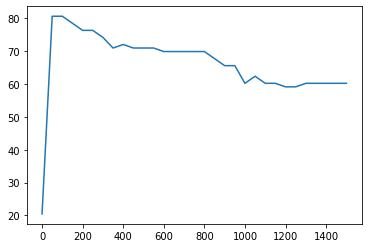

In [ ]:
size = np.array([])
accuracies = np.array([])

for i in range(1500, -10, -50): # Since we slice bagofwords into smaller parts, we start loop from bigger values
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, 3)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, False)
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, i, 'TF-IDF', 'PR+AB', False))
  size = np.append(size, np.array(i))
  accuracies = np.append(accuracies, np.array(accuracy))

print("Best BOW Size For Maximum Accuracy: " + str(size[np.argmax(accuracies)]))
print("Best Accuracy: " + str(accuracies[np.argmax(accuracies)]))
print("--------------------------------------")

plt.plot(size, accuracies)
plt.show()

**Experiment Results:** 
*   If we restrict number so much, accuracy gets worse since we lose most of important keywords.
*   If we don't restrict number so much, accuracy gets worse since we don't remove ordinary keywords.

###**Part-3.6: Effect of Keyword Dictionary Type**
Keyword types (unigram, bigram, both of them etc.) also affect models performance. Lets find best option.

In [ ]:
accuracies = list()
precisions = list()
recalls = list()

print("  --- If Only Unigram Keywords Are Preferred ---")
for i in range(5):
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, False, [True, False])
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 100, 'TF-IDF', 'PR+AB', False))
  accuracies.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)

print('Accuracy ' + str("{:.2f}".format(sum(accuracies) / len(accuracies))) + ' - Precision: ' + str("{:.2f}".format(sum(precisions) / len(precisions))) + ' - Recall: ' + str("{:.2f}".format(sum(recalls) / len(recalls))))
print("")
accuracies = list()
precisions = list()
recalls = list()

print("  --- If Only Bigram Keywords Are Preferred ---")
for i in range(5):
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, False, [False, True])
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 100, 'TF-IDF', 'PR+AB', False))
  accuracies.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)

print('Accuracy ' + str("{:.2f}".format(sum(accuracies) / len(accuracies))) + ' - Precision: ' + str("{:.2f}".format(sum(precisions) / len(precisions))) + ' - Recall: ' + str("{:.2f}".format(sum(recalls) / len(recalls))))
print("")
accuracies = list()
precisions = list()
recalls = list()

print("--- If Unigram and Bigram Keywords Are Preferred ---")
for i in range(5):
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, False)
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 100, 'TF-IDF', 'PR+AB', False))
  accuracies.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)

print('Accuracy ' + str("{:.2f}".format(sum(accuracies) / len(accuracies))) + ' - Precision: ' + str("{:.2f}".format(sum(precisions) / len(precisions))) + ' - Recall: ' + str("{:.2f}".format(sum(recalls) / len(recalls))))


  --- If Only Unigram Keywords Are Preferred ---
Accuracy 76.94 - Precision: 82.87 - Recall: 80.88

  --- If Only Bigram Keywords Are Preferred ---
Accuracy 15.72 - Precision: 3.15 - Recall: 20.00

--- If Unigram and Bigram Keywords Are Preferred ---
Accuracy 76.94 - Precision: 82.87 - Recall: 80.88


**Experiment Results:** 
*   Unigram --> High bias / low variance.
*   Bigram  --> Low bias  / high variance 
*   Selecting only bigrams is worst case according to performance metrics.
*   There is **no significant difference** between selecting unigram and selecting both of unigram and bigram, where **`DICTIONARY_SIZE`** is not quite big. Because bigram keywords' frequencies and importances are quite low.
*   According to part 3.5, best dictionary_size is 100 and there is no difference between selecting unigram and selecting both of unigram and bigram if dictionary_size is 100.

###**Part-3.7: Model Performance With Using Best Parameters (Parameter Tuning)**
**`According To Part 3.1:`** Only presence cases should be considered.

**`According To Part 3.2:`** Common stopwords should not be considered.

**`According To Part 3.3:`** TF-IDF calculations should be prefered.

**`According To Part 3.4:`** (This part was just printing most important keywords.)

**`According To Part 3.5:`** Limit keyword parameter should be 100.

**`According To Part 3.6:`** Both of unigram and bigram keywords should be selected.

Let's use these best parameters in order to get best model performance.

In [ ]:
accuracies = list()
precisions = list()
recalls = list()

print("    - Model Performance After Parameter Tuning -")
for i in range(5):
  print("          --- Current Fold Number : " + str(i+1) + " ---")
  trainSet, testSet = kFoldCrossValidationSplit(df[:], 5, i)
  bagOfWords, oppositeBagOfWords = BagOfWordsCreator(trainSet, False)
  accuracy, precision, recall = metric_evaluation([row[-1] for row in testSet], naiveBayesPredictor(bagOfWords, oppositeBagOfWords, trainSet, testSet, 100, 'TF-IDF', 'PR', False))
  accuracies.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  print(' Accuracy ' + str("{:.2f}".format(accuracy)) + ' - Precision: ' + str("{:.2f}".format(precision)) + ' - Recall: ' + str("{:.2f}".format(recall)))

print("")

print("- Average Model Performance After Parameter Tuning -")
print("Accuracy:  " + str("{:.2f}".format(sum(accuracies) / len(accuracies))))
print("Precision: " + str("{:.2f}".format(sum(precisions) / len(precisions))))
print("Recall:    " + str("{:.2f}".format(sum(recalls) / len(recalls))))

    - Model Performance After Parameter Tuning -
          --- Current Fold Number : 1 ---
 Accuracy 81.72 - Precision: 83.88 - Recall: 86.10
          --- Current Fold Number : 2 ---
 Accuracy 79.57 - Precision: 81.42 - Recall: 82.42
          --- Current Fold Number : 3 ---
 Accuracy 83.87 - Precision: 86.40 - Recall: 87.02
          --- Current Fold Number : 4 ---
 Accuracy 88.17 - Precision: 90.24 - Recall: 88.94
          --- Current Fold Number : 5 ---
 Accuracy 79.35 - Precision: 82.60 - Recall: 81.06

- Average Model Performance After Parameter Tuning -
Accuracy:  82.54
Precision: 84.91
Recall:    85.11
